# Setup


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import random
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.cluster import DBSCAN
import math
import statistics
pd.options.mode.chained_assignment = None  # default='warn'
import itertools
import json
from confidence_functions.confidence import *

#Convert CSV to Dataframe"C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\data\pairwise_user_experiment.csv"
data = pd.read_csv("./data/pairwise_user_experiment.csv", header=[0])
data["FOLDER"] = data["IN FILE"].apply(lambda x: "")
data["LAST MOD BY"] = data["LAST MOD BY"].apply(lambda x: x.split(" ")[0])
data

,IN FILE,CLIP LENGTH,OFFSET,DURATION,MAX FREQ,MIN FREQ,SAMPLE RATE,MANUAL ID,TIME_SPENT,LAST MOD BY,CONFIDENCE,RETIRED,COUNTED,FOLDER
0,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,1.1839,1.3399,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
1,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,6.9715,1.5479,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
2,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,8.8594,0.4500,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
3,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,9.9393,1.0800,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
4,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,15.1890,0.9299,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,22.3916,0.8100,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,
2244,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,23.7316,0.1600,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,
2245,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,24.2615,0.1200,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,
2246,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,24.7815,0.1600,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,


In [56]:
import time

 
confidence_funcs = [ get_silhoutte_confidence, get_silhoutte_users_confidence, fast_majority_vote, get_pairwise_iou]
confidence_funcs

def experiment_3(df, confidence_funcs, num_of_trials=10, json_name="experiment_results.json"):
    results = {}
    users = df["LAST MOD BY"].unique()
    files = df["IN FILE"].unique()
    for func in confidence_funcs:
        results[func.__name__] = {}
        for i in range (len(users)):
            results[func.__name__][i] = []
        results[func.__name__]["TIMING"] = []
    
    
    for trial in range(num_of_trials):
        start = time.time()
        print("============================")
        print(trial)
        file  = np.random.choice(files, size=None, replace=True, p=None)
        tmp_df = df[df["IN FILE"] == file]
        users = tmp_df["LAST MOD BY"].unique()

        to_be_randomly_inserted = np.tile(users, (1, 1))
        to_be_randomly_inserted = pd.DataFrame(to_be_randomly_inserted)
        to_be_randomly_inserted = to_be_randomly_inserted.apply(lambda x:np.random.shuffle(x.to_numpy()) or x.to_numpy(), axis=1)
        random_insertion_orders = to_be_randomly_inserted.values
        
        end = time.time()
        #print("Set Up", end - start)
        
        for insertion_order in random_insertion_orders:
            for func in confidence_funcs:
                start = time.time()
                for user_count in range(1,len(insertion_order)):
                    curr_insert = insertion_order[:user_count+1]
                    tmp_df_users = tmp_df[tmp_df["LAST MOD BY"].isin(curr_insert)]
                    try:
                        results[func.__name__][user_count].append(func(tmp_df_users, curr_insert))
                    except:
                        pass
                end = time.time()
                print(func.__name__, end - start)
                results[func.__name__]["TIMING"].append(end - start)
                    
        results["TRIAL COUNT"] = trial
        json_object = json.dumps(results, indent=4)
 
        # Writing to sample.json
        with open(json_name, "w") as outfile:
            outfile.write(json_object)
        
    return results


def process_results(experiment_results):
    #print(experiment_results)
    print ("trails ran",  experiment_results["TRIAL COUNT"])
    del experiment_results["TRIAL COUNT"]
    
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        print("Time for ", confidence_func, " was ", np.mean(confidence_dirc["TIMING"]))
        del confidence_dirc["TIMING"]
        users_count = list(confidence_dirc.keys())
        #for count in users_count:
        #    experiment_results[confidence_func][count] = np.array(confidence_dirc[count])#.mean()
    return experiment_results


def plot_change_in_ci(experiment_results):
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        
        users_count = list(confidence_dirc.keys())
        raw_score = list(confidence_dirc.values())
        CI = []
        #plot CI
        for count in users_count:
            if (count == 0):continue
            scores_for_count = np.array(raw_score[int(count)-1])                            
            ci = 0.1 * float(np.std(scores_for_count)) / float(np.mean(scores_for_count))
            CI.append(ci * 2)
        p = plt.plot(users_count[1:], CI, label=(confidence_func))
        

    #Throw in some fancy formatting
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title("Change in Confidence Interval of User Scores per Function")
    plt.xlabel("Number of users who annotated")
    plt.ylabel("CI of Function")
    plt.show()

def generate_graph_all(experiment_results):
    #For each filename, plot the performance of each confidence function
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        
        users_count = list(confidence_dirc.keys())
        raw_score = list(confidence_dirc.values())
        
        #plot mean
        score_mean = []
        for count in users_count:
            if (count == 0):continue
            score_mean.append(np.array(raw_score[int(count)]).mean())
        p = plt.plot(users_count[1:], score_mean, label=(confidence_func))
        #plot CI
        
        print(users_count)
        for count in users_count:
            if (count == 0):continue
            print(raw_score[int(count)])
            scores_for_count = np.array(raw_score[int(count)])
            y = scores_for_count.mean()
            ci = 0.1 * np.std(scores_for_count) / np.mean(scores_for_count)
            plt.fill_between([count], (y-ci), (y+ci), color=p[0].get_color(), alpha=0.5)
        

    #Throw in some fancy formatting
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title("Change in user agreement scores per Function")
    plt.xlabel("Number of users who annotated")
    plt.ylabel("Average Confidence of Function For Number Of Users")
    plt.show()


# Rerun Old Experiment

0
get_silhoutte_confidence 0.13750815391540527
get_silhoutte_users_confidence 0.13804101943969727
fast_majority_vote 0.44357991218566895
get_pairwise_iou 0.7372617721557617
1
get_silhoutte_confidence 0.36055779457092285
get_silhoutte_users_confidence 0.35810184478759766
fast_majority_vote 1.6704466342926025
get_pairwise_iou 3.804015874862671
2
get_silhoutte_confidence 0.1510307788848877
get_silhoutte_users_confidence 0.15703630447387695
fast_majority_vote 0.634685754776001
get_pairwise_iou 0.8518695831298828
3
get_silhoutte_confidence 0.36556196212768555
get_silhoutte_users_confidence 0.3656039237976074
fast_majority_vote 1.658850908279419
get_pairwise_iou 4.02147364616394
4
get_silhoutte_confidence 0.1770174503326416
get_silhoutte_users_confidence 0.17661309242248535
fast_majority_vote 0.4917793273925781
get_pairwise_iou 1.6601574420928955
5
get_silhoutte_confidence 0.22219419479370117
get_silhoutte_users_confidence 0.22894930839538574
fast_majority_vote 0.47269558906555176
get_pairwi

get_silhoutte_users_confidence 0.1607222557067871
fast_majority_vote 0.45895957946777344
get_pairwise_iou 1.459601640701294
42
get_silhoutte_confidence 0.15255117416381836
get_silhoutte_users_confidence 0.15932035446166992
fast_majority_vote 0.488600492477417
get_pairwise_iou 0.7028293609619141
43
get_silhoutte_confidence 0.37243056297302246
get_silhoutte_users_confidence 0.3434135913848877
fast_majority_vote 1.1788713932037354
get_pairwise_iou 2.502664566040039
44
get_silhoutte_confidence 0.21790409088134766
get_silhoutte_users_confidence 0.22003889083862305
fast_majority_vote 1.1146509647369385
get_pairwise_iou 1.7091493606567383
45
get_silhoutte_confidence 0.1271522045135498
get_silhoutte_users_confidence 0.12996697425842285
fast_majority_vote 0.5690083503723145
get_pairwise_iou 0.6509842872619629
46
get_silhoutte_confidence 0.2546355724334717
get_silhoutte_users_confidence 0.2561333179473877
fast_majority_vote 0.530494213104248
get_pairwise_iou 1.6321735382080078
47
get_silhoutte_c

get_silhoutte_users_confidence 0.2521030902862549
fast_majority_vote 1.527099370956421
get_pairwise_iou 3.1269562244415283
83
get_silhoutte_confidence 0.13655376434326172
get_silhoutte_users_confidence 0.13946914672851562
fast_majority_vote 0.4537687301635742
get_pairwise_iou 0.8262112140655518
84
get_silhoutte_confidence 0.11859917640686035
get_silhoutte_users_confidence 0.12137556076049805
fast_majority_vote 0.31352686882019043
get_pairwise_iou 0.7830970287322998
85
get_silhoutte_confidence 0.08111333847045898
get_silhoutte_users_confidence 0.08086180686950684
fast_majority_vote 0.2361462116241455
get_pairwise_iou 0.6111829280853271
86
get_silhoutte_confidence 0.23632478713989258
get_silhoutte_users_confidence 0.26044487953186035
fast_majority_vote 0.3293430805206299
get_pairwise_iou 0.7712042331695557
87
get_silhoutte_confidence 0.13187265396118164
get_silhoutte_users_confidence 0.13609743118286133
fast_majority_vote 0.4942629337310791
get_pairwise_iou 0.6224992275238037
88
get_silh

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice.
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice.
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\seanh\AppData\Roaming\Python\Python37

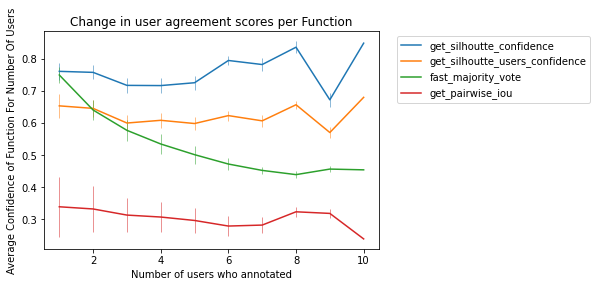

In [58]:
confidence_funcs = [ get_silhoutte_confidence, get_silhoutte_users_confidence, fast_majority_vote, get_pairwise_iou]
experiment_results = experiment_3(data, confidence_funcs, num_of_trials=100, json_name="experiment_results_old.json")
processed = process_results(experiment_results)
generate_graph_all(processed)

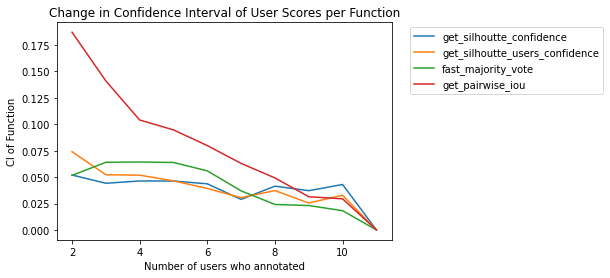

In [59]:
plot_change_in_ci(processed)

# Get JSON Copy of Last Experiment Ran

In [60]:
with open('./experiment_results.json', 'r') as fcc_file:
    experiment_results = json.load(fcc_file)
    print(experiment_results)

{'get_silhoutte_confidence': {'0': [], '1': [0.3563649052250318, 0.5903774597683469, 0.9746665925662353, 0.9311813921270669, 0.4104300129903845, 0.3978433186406213, 0.0, 0.30407130730889853, 0.3725080669987158, 0.2996703984127571, 0.32990276993598194, 0.5591496265843614, 0.9819875594708971, 0.29496024448026364, 0.47869213237663033, 0.0, 0.3988274630644245, 0.37440609493484295, 0.4924242356622268, 0.48660279020548974, 0.4807692246637642, 0.0, 0.3682646246980215, 0.3762228750428031, 0.2841154524879408, 0.0, 0.0, 0.5221085583902391, 0.990095405107789, 0.36231416980459796, 0.7284884508730045, 0.4650160536251593, 0.0, 0.3445199995028739, 0.9393458884186858, 0.3445199995028739, 0.37854815862775737, 0.3553246006870319, 0.0, 0.31688667297451656, 0.5628169258859382, 0.7921920139499294, 0.47869213237663033, 0.7676342432028034, 0.47751807736475355, 0.2506191785008715, 0.8925375029739722, 0.2734903803485126, 0.9499999965003028, 0.0, 0.0, 0.0, 0.4911677594052356, 0.4966356337108552, 0.2137880883200